# Imports

In [3]:
import requests, json 
import pandas as pd
import googlemaps
from datetime import datetime
import ast
import pandas as pd
from pandas.io.json import json_normalize
import geopy.distance
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns


## Connection to gmaps API

In [6]:
api_key='' #--> you need to create a maps api and copy here your key
gmaps = googlemaps.Client(key='')

In [7]:
url = "https://maps.googleapis.com/maps/api/place/textsearch/json?"
def get_data(query):
    #you pass this function a google maps search and it will give back the results ---> note that with
    #maps API you receive a maximum of 20 results per search

    r = requests.get(url + 'query=' + query +
                            '&key=' + api_key) 

    x = r.json() 
    y = x['results'] 
    return y

## We look in all the quartier of Zurich

In [14]:
# In this file there are information about the kreis and the quartiers of Zurich. I will use it to do a search for the 
# supermarkets in those places.

all_neighborhood=pd.read_csv("Bevoelkerungsentwicklung.csv",delimiter=";")
quartier_list=all_neighborhood["Quartier"][all_neighborhood["Year"]==2018]
quartier_list=list(quartier_list)
quartier_list=quartier_list[1:]

all_neighborhood.head()

,City,Kreis,Quartier,Year,Total,0-9,43739,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-99,100+,Unnamed: 16
0,Zürich,Zürich,Zürich,2018,428737,42380,30199,70558,90897,64069,50770,33871,25495,16089,4316.0,93.0,
1,Zürich,Kreis 1,Kreis 1,2018,5750,286,273,1088,1143,774,820,592,509,194,69.0,2.0,
2,Zürich,Kreis 2,Kreis 2,2018,34877,4091,2654,4722,7400,5118,4001,2665,2186,1508,521.0,11.0,
3,Zürich,Kreis 2,Wollishofen,2018,18923,2181,1306,2607,3939,2775,2219,1478,1216,891,305.0,6.0,
4,Zürich,Kreis 2,Leimbach,2018,6320,872,740,745,1050,853,714,519,421,297,107.0,2.0,


In [18]:
df_shops=pd.DataFrame()

In [19]:
for quartier in quartier_list: 
    a=get_data('supermarket in '+ quartier)
    for i in range(len(a)):
        try:
            formatted_address=a[i]["formatted_address"]
        except:
            formatted_address="empty"
        
        try:
            geometry=a[i]["geometry"]
        except:
            geometry="empty"
        
        try:
            id_=a[i]["id"]
        except:
            id_="empty"
        
        try:
            name=a[i]["name"]
        except:
            name="empty"    
        
        try:
            types=a[i]["types"]
        except:
            types="empty"
        
        try:
            user_ratings_total=a[i]["user_ratings_total"]
        except:
            user_ratings_total="empty"
         
        try:
            rating=a[i]["rating"]
        except:
            rating="empty"
        
            
            
            
        #print(formatted_address) 
        #print(geometry)
            
        df_shops = df_shops.append({
           "formatted_address":formatted_address,
           "geometry":geometry,
            "id":id_,
            "name":name,
            "types":types,
            "user_ratings_total":user_ratings_total,
            "rating":rating,
            "quartier":quartier
                }, ignore_index = True
              )
                
        

In [30]:
df_shops.to_csv("supermarket_in_zurich_by_quartier.csv", index=False)

In [4]:
#you can download the file "supermarket_in_zurich_by_quartier.csv" and start from here or collect yourself the data

In [5]:
df_shops=pd.read_csv("supermarket_in_zurich_by_quartier.csv") #even if we search quartier by quartier the gmaps' API
                                                              #includes all the supermart around that area. We want to 
                                                              # create a column that actually tell us in which quartier a 
                                                              # given supermarket is
df_shops.head()

,formatted_address,geometry,id,name,quartier,rating,types,user_ratings_total
0,"Bahnhofpl. 9/F7, 8001 Zürich, Switzerland","{'location': {'lat': 47.3771126, 'lng': 8.5393...",3a286bedc2bf2db640f38da2b0335db7117890cf,ShopVilleMärt,Kreis 1,4.4,"['supermarket', 'grocery_or_supermarket', 'foo...",24.0
1,"Bahnhofbrücke 1, 8001 Zürich, Switzerland","{'location': {'lat': 47.3764584, 'lng': 8.5423...",f4f79b81ea0d4ece112490f46cfbed4a4c98db84,Coop Supermarkt Zürich Bahnhofbrücke,Kreis 1,4.3,"['supermarket', 'grocery_or_supermarket', 'foo...",2110.0
2,"Hauptbahnhof, 8001 Zürich, Switzerland","{'location': {'lat': 47.3782635, 'lng': 8.5404...",6f898df83ae1b603a902ccad260df28097036819,Migros Hauptbahnhof,Kreis 1,4.2,"['grocery_or_supermarket', 'supermarket', 'foo...",673.0
3,"Löwenstrasse 31-35, 8001 Zürich, Switzerland","{'location': {'lat': 47.37533070000001, 'lng':...",f209f93c6e8769412c024c8dc57e40daebb0a32a,Migros,Kreis 1,4.3,"['grocery_or_supermarket', 'supermarket', 'foo...",1376.0
4,"Hauptbahnhof, 8001 Zürich, Switzerland","{'location': {'lat': 47.3778429, 'lng': 8.5407...",adc6588340d9fede626af3f9c7379d95d1c640ed,migrolino-Shop,Kreis 1,3.8,"['grocery_or_supermarket', 'food', 'point_of_i...",29.0


## We want to pass to swiss coordinates in order to check which supermarket is in which kreis

In [6]:
#The data from maps have standard coordinates, but we have a shape file only with Swiss coordinates (!!Yes they often use
# a different system!). We will need to convert them in order to proceed in the analysis. The following functions 
# serve this porpuse.

import math

# Convert CH y/x/h to WGS height
def CHtoWGSheight(y, x, h, plus):
    # Axiliary values (% Bern)
    if plus:
        y_aux = (y - 2600000) / 1000000
        x_aux = (x - 1200000) / 1000000
    else:
        y_aux = (y - 2600000) / 1000000
        x_aux = (x - 1200000) / 1000000
    print("CHtoWGSheight", plus)
    h = (h + 49.55) - (12.60 * y_aux) - (22.64 * x_aux)
    return h

# Convert CH y/x to WGS lat
def CHtoWGSlat(y, x, plus):
    # Axiliary values (% Bern)
    if plus:
        y_aux = (y - 2600000) / 1000000
        x_aux = (x - 1200000) / 1000000
    else:
        y_aux = (y - 2600000) / 1000000
        x_aux = (x - 1200000) / 1000000
    print("CHtoWGSlat", plus)
    lat = (16.9023892 + (3.238272 * x_aux)) + \
            - (0.270978 * pow(y_aux, 2)) + \
            - (0.002528 * pow(x_aux, 2)) + \
            - (0.0447 * pow(y_aux, 2) * x_aux) + \
            - (0.0140 * pow(x_aux, 3))
    # Unit 10000" to 1" and convert seconds to degrees (dec)
    lat = (lat * 100) / 36
    return round(lat,7)

# Convert CH y/x to WGS long
def CHtoWGSlng(y, x, plus):
    # Axiliary values (% Bern)
    if plus:
        y_aux = (y - 2600000) / 1000000
        x_aux = (x - 1200000) / 1000000
    else:
        y_aux = (y - 2600000) / 1000000
        x_aux = (x - 1200000) / 1000000
    print("CHtoWGSlng", plus)
    lng = (2.6779094 + (4.728982 * y_aux) + \
            + (0.791484 * y_aux * x_aux) + \
            + (0.1306 * y_aux * pow(x_aux, 2))) + \
            - (0.0436 * pow(y_aux, 3))
    # Unit 10000" to 1" and convert seconds to degrees (dec)
    lng = (lng * 100) / 36
    return round(lng, 7)

# Convert decimal angle (° dec) to sexagesimal angle (dd.mmss,ss)
def DecToSexAngle(dec):
    degree = int(math.floor(dec))
    minute = int(math.floor((dec - degree) * 60))
    second = (((dec - degree) * 60) - minute) * 60
    return degree + (float(minute) / 100) + (second / 10000)

# Convert sexagesimal angle (dd.mmss,ss) to seconds
def SexAngleToSeconds(dms):
    degree = 0 
    minute = 0 
    second = 0
    degree = math.floor(dms)
    minute = math.floor((dms - degree) * 100)
    second = (((dms - degree) * 100) - minute) * 100
    return second + (minute * 60) + (degree * 3600)

# Convert sexagesimal angle (dd.mmss) to decimal angle (degrees)
def SexToDecAngle(dms):
    degree = 0
    minute = 0
    second = 0
    degree = math.floor(dms)
    minute = math.floor((dms - degree) * 100)
    second = (((dms - degree) * 100) - minute) * 100
    return degree + (minute / 60) + (second / 3600)

# Convert WGS lat/long (° dec) and height to CH h
def WGStoCHh(lat, lng, h):
    lat = DecToSexAngle(lat)
    lng = DecToSexAngle(lng)
    lat = SexAngleToSeconds(lat)
    lng = SexAngleToSeconds(lng)
    # Axiliary values (% Bern)
    lat_aux = (lat - 169028.66) / 10000
    lng_aux = (lng - 26782.5) / 10000
    h = (h - 49.55) + (2.73 * lng_aux) + (6.94 * lat_aux)
    return h

# Convert WGS lat/long (° dec) to CH x
def WGStoCHx(lat, lng, plus=False):
    lat = DecToSexAngle(lat)
    lng = DecToSexAngle(lng)
    lat = SexAngleToSeconds(lat)
    lng = SexAngleToSeconds(lng)
    # Axiliary values (% Bern)
    lat_aux = (lat - 169028.66) / 10000
    lng_aux = (lng - 26782.5) / 10000
    y = ((200147.07 + (308807.95 * lat_aux) + \
        + (3745.25 * pow(lng_aux, 2)) + \
        + (76.63 * pow(lat_aux,2))) + \
        - (194.56 * pow(lng_aux, 2) * lat_aux)) + \
        + (119.79 * pow(lat_aux, 3))
    if plus:
        return int(round(y + 1000000, 0))
    else:
        return int(round(y, 0))

# Convert WGS lat/long (° dec) to CH y
def WGStoCHy(lat, lng, plus=False):
    lat = DecToSexAngle(lat)
    lng = DecToSexAngle(lng)
    lat = SexAngleToSeconds(lat)
    lng = SexAngleToSeconds(lng)
    # Axiliary values (% Bern)
    lat_aux = (lat - 169028.66) / 10000
    lng_aux = (lng - 26782.5) / 10000
    x = (600072.37 + (211455.93 * lng_aux)) + \
        - (10938.51 * lng_aux * lat_aux) + \
        - (0.36 * lng_aux * pow(lat_aux, 2)) + \
        - (44.54 * pow(lng_aux, 3))

    if plus:
        return int(round(x + 2000000, 0))
    else:
        return int(round(x, 0))

def LV03toWGS84(east, north, height):
    '''
    Convert LV03 to WGS84 Return a array of double that contain lat, long,
    and height
    '''
    d = []
    d.append(CHtoWGSlat(east, north))
    d.append(CHtoWGSlng(east, north))
    d.append(CHtoWGSheight(east, north, height))
    return d

def LV03ptoWGS84(east, north, plus=True):
    '''
    Convert LV03+ to WGS84 Return a array of double that contain lat, long,
    and height
    '''
    d = []
    d.append(CHtoWGSlat(east, north, plus))
    d.append(CHtoWGSlng(east, north, plus))
    return d

def WGS84toLV03(latitude, longitude, ellHeight):
    '''
    Convert WGS84 to LV03 Return an array of double that contaign east,
    north, and height
    '''
    d = []
    d.append(WGStoCHy(latitude, longitude))
    d.append(WGStoCHx(latitude, longitude))
    d.append(WGStoCHh(latitude, longitude, ellHeight))
    return d

def WGS84toLV03p(latitude, longitude, plus=True):
    '''
    Convert WGS84 to LV03+ Return an array of double that contaign east and north
    '''
    d = []
    d.append(WGStoCHy(latitude, longitude, plus))
    d.append(WGStoCHx(latitude, longitude, plus))
    return d

#example
WGS84toLV03p(47.3748857,8.4996759)

[2680134, 1247658]

In [7]:
df_shops["geometry"]=df_shops["geometry"].apply(ast.literal_eval)
swiss_coordinate=[]

for j in range(len(df_shops)):
    swiss_coordinate.append(WGS84toLV03p(df_shops["geometry"][j]["location"]["lat"],df_shops["geometry"][j]["location"]["lng"]))

df_shops["swiss coordinates"]=swiss_coordinate


In [8]:
df_shops.to_csv("supermarket_in_zurich_by_quartier_with_swiss_coo.csv", index=False) # I save the file
df_swiss_shops=pd.read_csv("supermarket_in_zurich_by_quartier_with_swiss_coo_extended.csv") #this csv contains the district
                                                                                            #in which each supermarket is.
                                                                                            #It is obtained from the previous 
                                                                                            #one and using the code in ""
df_swiss_shops=df_swiss_shops.drop_duplicates("id") # clean the data
df_swiss_shops.head()

,Unnamed: 0,formatted_address,geometry,id,name,quartier,rating,types,user_ratings_total,swiss coordinates,district
0,0,"Bahnhofpl. 9/F7, 8001 Zürich, Switzerland","{'location': {'lat': 47.3771126, 'lng': 8.5393...",3a286bedc2bf2db640f38da2b0335db7117890cf,ShopVilleMärt,Kreis 1,4.4,"['supermarket', 'grocery_or_supermarket', 'foo...",24.0,"[2683124, 1247947]","[1, 'City', 14]"
1,1,"Bahnhofbrücke 1, 8001 Zürich, Switzerland","{'location': {'lat': 47.3764584, 'lng': 8.5423...",f4f79b81ea0d4ece112490f46cfbed4a4c98db84,Coop Supermarkt Zürich Bahnhofbrücke,Kreis 1,4.3,"['supermarket', 'grocery_or_supermarket', 'foo...",2104.0,"[2683354, 1247877]","[1, 'Lindenhof', 13]"
2,2,"Hauptbahnhof, 8001 Zürich, Switzerland","{'location': {'lat': 47.3782635, 'lng': 8.5404...",6f898df83ae1b603a902ccad260df28097036819,Migros Hauptbahnhof,Kreis 1,4.2,"['grocery_or_supermarket', 'supermarket', 'foo...",671.0,"[2683209, 1248076]","[1, 'City', 14]"
3,3,"Löwenstrasse 31-35, 8001 Zürich, Switzerland","{'location': {'lat': 47.37533070000001, 'lng':...",f209f93c6e8769412c024c8dc57e40daebb0a32a,Migros,Kreis 1,4.3,"['grocery_or_supermarket', 'supermarket', 'foo...",1374.0,"[2682908, 1247746]","[1, 'City', 14]"
4,4,"Hauptbahnhof, 8001 Zürich, Switzerland","{'location': {'lat': 47.3778429, 'lng': 8.5407...",adc6588340d9fede626af3f9c7379d95d1c640ed,migrolino-Shop,Kreis 1,3.8,"['grocery_or_supermarket', 'food', 'point_of_i...",29.0,"[2683229, 1248029]","[1, 'City', 14]"


In [9]:
#some more cleaning
quartier=[]
for i in range(len(df_swiss_shops)):
    try:
        quartier.append(ast.literal_eval(df_swiss_shops.iloc[i]["district"])[1])
    except:
        quartier.append("empty")
df_swiss_shops["quartier"]=quartier
shop_per_quartier=df_swiss_shops.groupby(quartier).count() # I count how many shops there are in each quartier and assign
                                                           # this to a new dataframe

In [10]:
df_swiss_shops.groupby(quartier).count().head()

,Unnamed: 0,formatted_address,geometry,id,name,quartier,rating,types,user_ratings_total,swiss coordinates,district
Affoltern,15,15,15,15,15,15,15,15,15,15,15
Albisrieden,12,12,12,12,12,12,12,12,12,12,12
Alt-Wiedikon,10,10,10,10,10,10,10,10,10,10,10
Altstetten,21,21,21,21,21,21,21,21,21,21,21
City,14,14,14,14,14,14,14,14,14,14,14


## I want now to merge the dataframe with information about supermarket per quartier and information about population statistics 

In [11]:
all_neighborhood = pd.read_csv("Population_Zurich_1.csv", delimiter=";", encoding="ISO-8859–1") 
#this dataframe is available at www.
all_neighborhood.head()

,City,Kreis_id,Kreis,Quartier_ID,Quartier,Year,Total,0-9,43739,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-99,100+
0,Zürich,0.0,Zürich,NaN,Zürich,2018,428737.0,42380.0,30199.0,70558.0,90897.0,64069.0,50770.0,33871.0,25495.0,16089.0,4316.0,93.0
1,Zürich,1.0,Kreis 1,NaN,Kreis 1,2018,5750.0,286.0,273.0,1088.0,1143.0,774.0,820.0,592.0,509.0,194.0,69.0,2.0
2,Zürich,NaN,Kreis 1,11.0,Rathaus,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Zürich,NaN,Kreis 1,12.0,Hochschulen,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Zürich,NaN,Kreis 1,13.0,Lindenhof,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
shop_population=shop_per_quartier.merge(all_neighborhood, left_index=True, right_on='Quartier')
shop_population=shop_population.drop(['formatted_address', 'Unnamed: 0',"geometry","name","quartier","rating","types","user_ratings_total","swiss coordinates","district"], axis=1)
shop_population=shop_population.rename(columns = {'id':'number of shops'})
shop_pop_2018=shop_population[shop_population["Year"]==2018]
shop_pop_2018.head()
#merging and cleaning

,number of shops,City,Kreis_id,Kreis,Quartier_ID,Quartier,Year,Total,0-9,43739,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-99,100+
40,15,Zürich,NaN,Kreis 11,111.0,Affoltern,2018,26562.0,3186.0,2358.0,4709.0,4700.0,3752.0,3065.0,2152.0,1532.0,981.0,127.0,NaN
34,12,Zürich,NaN,Kreis 9,91.0,Albisrieden,2018,22304.0,2611.0,1305.0,2964.0,4677.0,3423.0,2463.0,1827.0,1609.0,1123.0,296.0,6.0
11,10,Zürich,NaN,Kreis 3,31.0,Alt-Wiedikon,2018,17956.0,1777.0,1091.0,2988.0,4737.0,2916.0,1915.0,1148.0,802.0,468.0,108.0,6.0
35,21,Zürich,NaN,Kreis 9,92.0,Altstetten,2018,33461.0,2919.0,2380.0,5664.0,7134.0,4798.0,3991.0,2762.0,2092.0,1406.0,313.0,2.0
9,6,Zürich,NaN,Kreis 2,24.0,Enge,2018,9634.0,1038.0,608.0,1370.0,2411.0,1490.0,1068.0,668.0,549.0,320.0,109.0,3.0


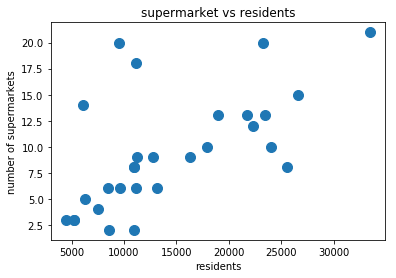

In [13]:
#Each dot represents a quartier. We plot number of residents in the x-axis, number of supermarket on the y-axis
ax = shop_pop_2018.plot(x='Total', y='number of shops', style='o',markersize=10, title='supermarket vs residents',legend=False)
ax.set_xlabel("residents")
ax.set_ylabel("number of supermarkets")
None

In [14]:
#The following are the quartiers in the upper left side of the graph. From locals inside we know that these are 
#quartiers were a lot of people go to work and few people live. We think that the high number of supermarket might be 
#explained by this fact. From here the idea to distinguish between large and small supermarkets and check whether 
#this is actually a good explanation.
shop_population[(shop_population["Total"]<15000) & (shop_population["Year"]<2020) & (shop_population['number of shops']>12)]

,number of shops,City,Kreis_id,Kreis,Quartier_ID,Quartier,Year,Total,0-9,43739,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-99,100+
20,14,Zürich,NaN,Kreis 5,52.0,Escher Wyss,2018,6066.0,547.0,214.0,1001.0,1960.0,1135.0,681.0,329.0,159.0,36.0,4.0,NaN
19,20,Zürich,NaN,Kreis 5,51.0,Gewerbeschule,2018,9513.0,666.0,501.0,1723.0,2502.0,1619.0,1231.0,671.0,338.0,196.0,65.0,1.0
16,18,Zürich,NaN,Kreis 4,42.0,Langstrasse,2018,11111.0,519.0,231.0,2421.0,3413.0,1827.0,1428.0,705.0,382.0,157.0,27.0,1.0


## Distinguish between large and small supermarkets

In [15]:
df_swiss_shops["name"]=df_swiss_shops["name"].str.lower()
dimension_market=[]

clean_name="(coop|migros|lidl|aldi|spar|asia|voi|denner|volg|alima|maxi|super|market)" #<--- big supermarket
df_swiss_shops["match"]=df_swiss_shops["name"].str.extract(clean_name)

mini="(pronto|migrolino|express|kiosk|shell|avec)" #<--- small supermarket
df_swiss_shops["mini"]=df_swiss_shops["name"].str.extract(mini)

In [16]:
df_swiss_shops.head()

,Unnamed: 0,formatted_address,geometry,id,name,quartier,rating,types,user_ratings_total,swiss coordinates,district,match,mini
0,0,"Bahnhofpl. 9/F7, 8001 Zürich, Switzerland","{'location': {'lat': 47.3771126, 'lng': 8.5393...",3a286bedc2bf2db640f38da2b0335db7117890cf,shopvillemärt,City,4.4,"['supermarket', 'grocery_or_supermarket', 'foo...",24.0,"[2683124, 1247947]","[1, 'City', 14]",NaN,NaN
1,1,"Bahnhofbrücke 1, 8001 Zürich, Switzerland","{'location': {'lat': 47.3764584, 'lng': 8.5423...",f4f79b81ea0d4ece112490f46cfbed4a4c98db84,coop supermarkt zürich bahnhofbrücke,Lindenhof,4.3,"['supermarket', 'grocery_or_supermarket', 'foo...",2104.0,"[2683354, 1247877]","[1, 'Lindenhof', 13]",coop,NaN
2,2,"Hauptbahnhof, 8001 Zürich, Switzerland","{'location': {'lat': 47.3782635, 'lng': 8.5404...",6f898df83ae1b603a902ccad260df28097036819,migros hauptbahnhof,City,4.2,"['grocery_or_supermarket', 'supermarket', 'foo...",671.0,"[2683209, 1248076]","[1, 'City', 14]",migros,NaN
3,3,"Löwenstrasse 31-35, 8001 Zürich, Switzerland","{'location': {'lat': 47.37533070000001, 'lng':...",f209f93c6e8769412c024c8dc57e40daebb0a32a,migros,City,4.3,"['grocery_or_supermarket', 'supermarket', 'foo...",1374.0,"[2682908, 1247746]","[1, 'City', 14]",migros,NaN
4,4,"Hauptbahnhof, 8001 Zürich, Switzerland","{'location': {'lat': 47.3778429, 'lng': 8.5407...",adc6588340d9fede626af3f9c7379d95d1c640ed,migrolino-shop,City,3.8,"['grocery_or_supermarket', 'food', 'point_of_i...",29.0,"[2683229, 1248029]","[1, 'City', 14]",NaN,migrolino


In [17]:
df_swiss_shops.to_csv("zurich_shops.csv", index=False)
# df_swiss_shops.isnull().sum() #count matching
visual_big_market=df_swiss_shops.dropna(subset=['match'])
visual_big=visual_big_market.groupby("quartier").count()
visual_big.head()

,Unnamed: 0,formatted_address,geometry,id,name,rating,types,user_ratings_total,swiss coordinates,district,match,mini
quartier,,,,,,,,,,,,
Affoltern,8,8,8,8,8,8,8,8,8,8,8,0
Albisrieden,8,8,8,8,8,8,8,8,8,8,8,0
Alt-Wiedikon,7,7,7,7,7,7,7,7,7,7,7,1
Altstetten,18,18,18,18,18,18,18,18,18,18,18,4
City,10,10,10,10,10,10,10,10,10,10,10,2


In [18]:
shop_population_big=visual_big.merge(all_neighborhood, left_index=True, right_on='Quartier')
shop_population_big_2018=shop_population_big[shop_population["Year"]==2018]
#shop_population_big_2018.plot(x='Total', y='id', style='o');
pop_x=list(shop_population_big_2018["Total"])
pop_y=shop_population_big_2018["id"].tolist()
pop_x=[[i] for i in pop_x]

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


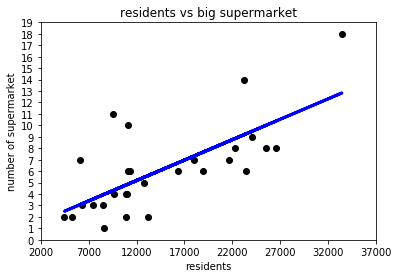

Coefficients: 
 0.0003563094934577927


In [19]:
# I now plot the relation between residents and number of supermarket only considering large supermarkets

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(pop_x, pop_y)

plt.scatter(pop_x, pop_y,  color='black')
plt.plot(pop_x, regr.predict(pop_x), color='blue', linewidth=3)


plt.xlabel("residents")
plt.ylabel("number of supermarket")
plt.title('residents vs big supermarket')

plt.xticks((np.arange(2000,40000,5000)))
plt.yticks((np.arange(20)))
plt.show()

slop_1=regr.coef_[0]
print('Coefficients: \n', slop_1) #I do not report sd but is significative


## I want to use the projections on the population growth made available for the quartiers of Zurich to predict how big is the space for new supermarket 

In [20]:
df_growth=pd.read_csv("Population_growth_2018_2025.csv") # This file is a modification of available online data and 
                                                         #report statistics on population growth forecast
df_growth.head()

,Unnamed: 0,City,Kreis_id,Kreis,Quartier_ID,Quartier,Year,Total,0-9,43739,20-29,30-39,40-49,50-59,60-69,70-79,80-89,90-99,100+,delta
0,0,Zürich,0.0,Kreis 1,11.0,Rathaus,2018,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
1,1,Zürich,0.0,Kreis 1,12.0,Hochschulen,2018,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
2,2,Zürich,0.0,Kreis 1,13.0,Lindenhof,2018,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
3,3,Zürich,0.0,Kreis 1,14.0,City,2018,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
4,4,Zürich,0.0,Kreis 2,21.0,Wollishofen,2018,18923,2181.0,1306.0,2607.0,3939.0,2775.0,2219.0,1478.0,1216.0,891.0,305.0,6.0,2277.0


In [21]:
df_growth=df_growth[df_growth["Year"]==2018]
df_growth["market_delta"]=df_growth["delta"]*slop_1 #population growth times the parameter measuring the increase in pop vs supermarket
df_growth=df_growth.sort_values("market_delta", ascending=False)
df_growth.head()

,Unnamed: 0,City,Kreis_id,Kreis,Quartier_ID,Quartier,Year,Total,0-9,43739,...,30-39,40-49,50-59,60-69,70-79,80-89,90-99,100+,delta,market_delta
30,30,Zürich,0.0,Kreis 11,119.0,Seebach,2018,25568,2754.0,2033.0,...,5065.0,3720.0,2985.0,1955.0,1434.0,843.0,135.0,0.0,7082.0,2.523384
25,25,Zürich,0.0,Kreis 9,92.0,Altstetten,2018,33461,2919.0,2380.0,...,7134.0,4798.0,3991.0,2762.0,2092.0,1406.0,313.0,2.0,5339.0,1.902336
28,28,Zürich,0.0,Kreis 11,111.0,Affoltern,2018,26562,3186.0,2358.0,...,4700.0,3752.0,3065.0,2152.0,1532.0,981.0,127.0,0.0,3438.0,1.224992
33,33,Zürich,0.0,Kreis 12,123.0,Hirzenbach,2018,12801,1431.0,1252.0,...,2224.0,1700.0,1433.0,993.0,685.0,568.0,147.0,4.0,3049.0,1.086388
14,14,Zürich,0.0,Kreis 5,52.0,Escher Wyss,2018,6066,547.0,214.0,...,1960.0,1135.0,681.0,329.0,159.0,36.0,4.0,0.0,2284.0,0.813811


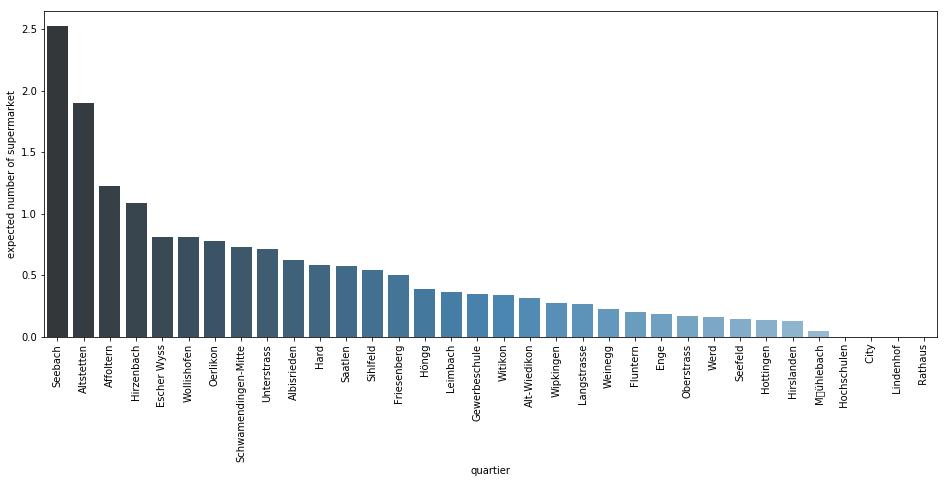

In [22]:
# Representation of Zurich quartier and the expected growth in supermarket
plt.figure(figsize=(16, 6))

ax= sns.barplot(x=df_growth["Quartier"], y=df_growth["market_delta"],  palette="Blues_d")
ax.set(xlabel='quartier', ylabel='expected number of supermarket')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()


In [23]:
df_growth.to_csv("growth_population_rate_2018_2025.csv", index=False)